<a href="https://colab.research.google.com/github/Bahaakhalled/Bank-Marketing-Classification/blob/main/Bank_Term_Deposit_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
import datetime
from pathlib import Path
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import fbeta_score, make_scorer,confusion_matrix,accuracy_score
import time as time
from sklearn.svm import SVC

In [3]:
my_file = Path("bank.csv")
if my_file.is_file()==False:
  !wget 'https://raw.githubusercontent.com/Bahaakhalled/Bank-Marketing-Classification/main/bank-full.csv'
  !wget 'https://raw.githubusercontent.com/Bahaakhalled/Bank-Marketing-Classification/main/bank.csv'

--2022-10-19 10:00:55--  https://raw.githubusercontent.com/Bahaakhalled/Bank-Marketing-Classification/main/bank-full.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4610348 (4.4M) [text/plain]
Saving to: ‘bank-full.csv’

bank-full.csv       100%[===================>]   4.40M  --.-KB/s    in 0.02s   

2022-10-19 10:00:55 (239 MB/s) - ‘bank-full.csv’ saved [4610348/4610348]

--2022-10-19 10:00:56--  https://raw.githubusercontent.com/Bahaakhalled/Bank-Marketing-Classification/main/bank.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK


https://archive.ics.uci.edu/ml/datasets/Bank+Marketing


In [4]:
bank=pd.read_csv('bank-full.csv',sep=';')
banktwo=pd.read_csv('bank.csv',sep=';')

In [5]:
bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [6]:
bank.rename(columns={'default': 'Failed Payments', 'duration': 'last contact duration','previous':'previous contacts','y':'Term Deposit','housing':'housing loan','loan':'personal loan','campaign':'ncontacts','pdays':'last contact'}, inplace=True)

In [7]:
bank.shape

(45211, 17)

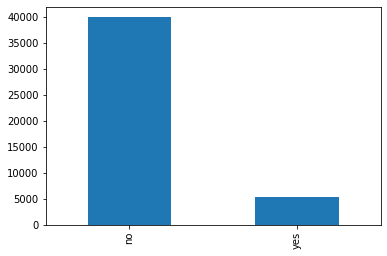

In [8]:
bank['Term Deposit'].value_counts().plot(kind='bar')

Regarding imbalanced data i'm going to continue without balancing the data as taking a term deposit is clearly a specific result so i won't be creating any synthetic points to balance, i will most likely oversample it if required after creating the base model

In [9]:
cols=bank.loc[:,bank.nunique()==2].columns
for j in cols:
  bank[j]=bank[j].map({'yes': 1, 'no': 0})
  
bank.month=bank.month.map({'jan': 1, 'feb': 2,'mar': 3, 'apr': 4,'may': 5, 'jun': 6,'jul': 7, 'aug': 8,'sep': 9, 'oct': 10,'nov': 11, 'dec': 12})

for j in bank.columns:
  bank[j]=bank[j].replace('unknown',pd.NA)

The below cell displays the percentage of missing data in every column containing missing values

In order to sort the missing values i decided to:-

1)job:drop na(0.6% only of the column were missing)

2)education: drop na (4% were missing)

3)contact: fill mode(91% of data had cellular as value)

4)poutcome: drop column(81% were missing)

In [10]:
bank.loc[:,bank.isnull().sum()>0].isnull().sum()/bank.shape[0]*100

job           0.637013
education     4.107407
contact      28.798301
poutcome     81.747805
dtype: float64

In [11]:
bank.contact.dropna().value_counts()/bank.contact.dropna().shape[0]*100

cellular     90.972632
telephone     9.027368
Name: contact, dtype: float64

In [12]:
missing=(bank.isnull().sum().sum()/np.product(bank.shape) ) * 100
print('Data Missing: ',missing,'%')

Data Missing:  6.781795684808617 %


In [13]:
print(int(missing),' % of the cells are missing is low but that is',bank.shape[0] - bank.dropna().shape[0],'out of the',bank.shape[0],'rows given')

6  % of the cells are missing is low but that is 37369 out of the 45211 rows given


In [14]:
bank=bank.drop(columns='poutcome',axis=1)
bank['contact']=bank['contact'].replace(pd.NA,bank.contact.mode()[0])
bank = bank.dropna()

Lets look at each columns distribution

In [15]:
bank

,age,job,marital,education,Failed Payments,balance,housing loan,personal loan,contact,day,month,last contact duration,ncontacts,last contact,previous contacts,Term Deposit
0,58,management,married,tertiary,0,2143,1,0,cellular,5,5,261,1,-1,0,0
1,44,technician,single,secondary,0,29,1,0,cellular,5,5,151,1,-1,0,0
2,33,entrepreneur,married,secondary,0,2,1,1,cellular,5,5,76,1,-1,0,0
5,35,management,married,tertiary,0,231,1,0,cellular,5,5,139,1,-1,0,0
6,28,management,single,tertiary,0,447,1,1,cellular,5,5,217,1,-1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,0,825,0,0,cellular,17,11,977,3,-1,0,1
45207,71,retired,divorced,primary,0,1729,0,0,cellular,17,11,456,2,-1,0,1
45208,72,retired,married,secondary,0,5715,0,0,cellular,17,11,1127,5,184,3,1
45209,57,blue-collar,married,secondary,0,668,0,0,telephone,17,11,508,4,-1,0,0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f70bb2e1710>,
      dtype=object)

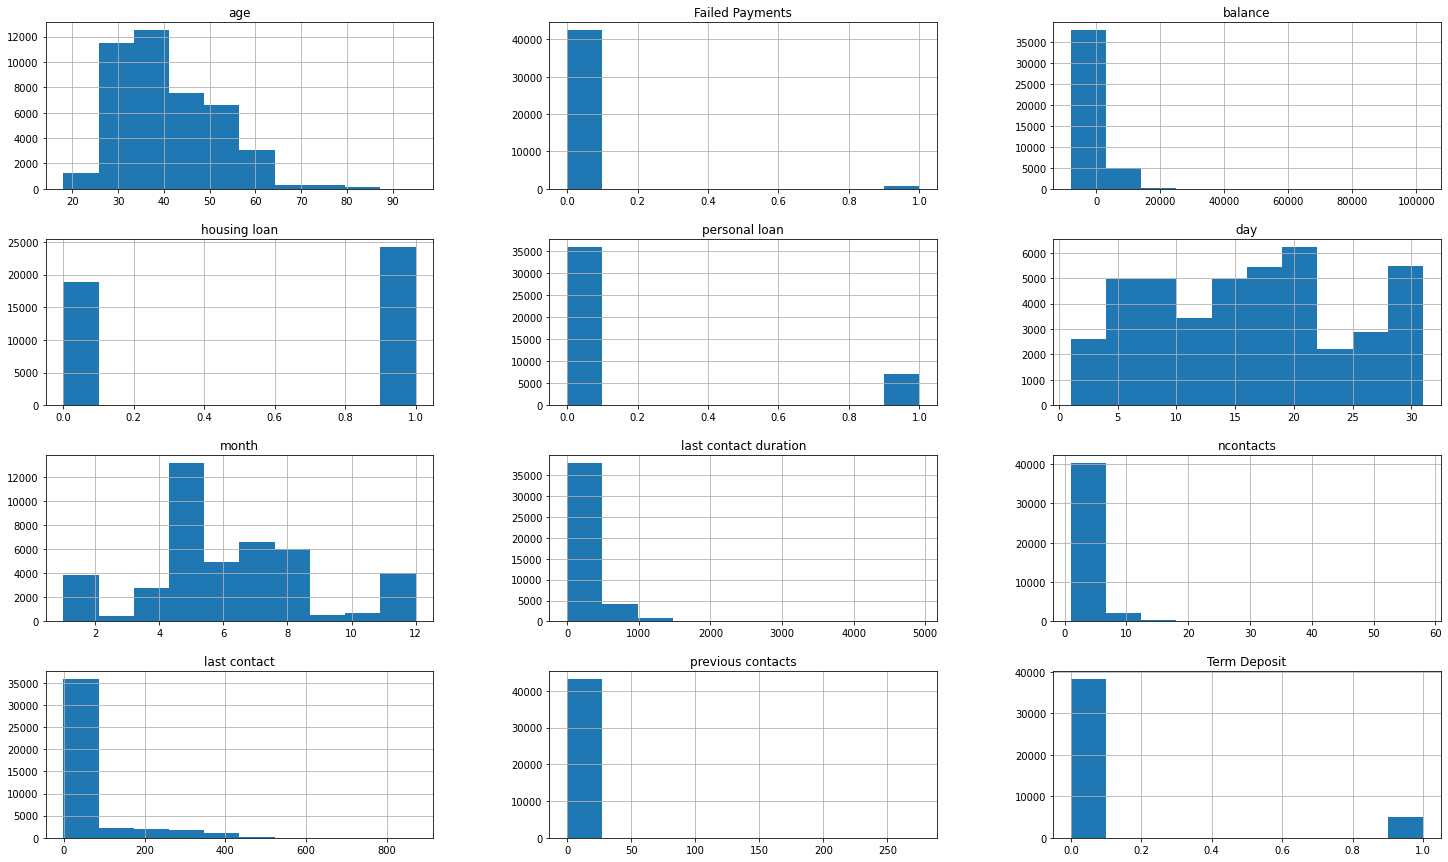

In [16]:
bank.hist(figsize=(25,15))

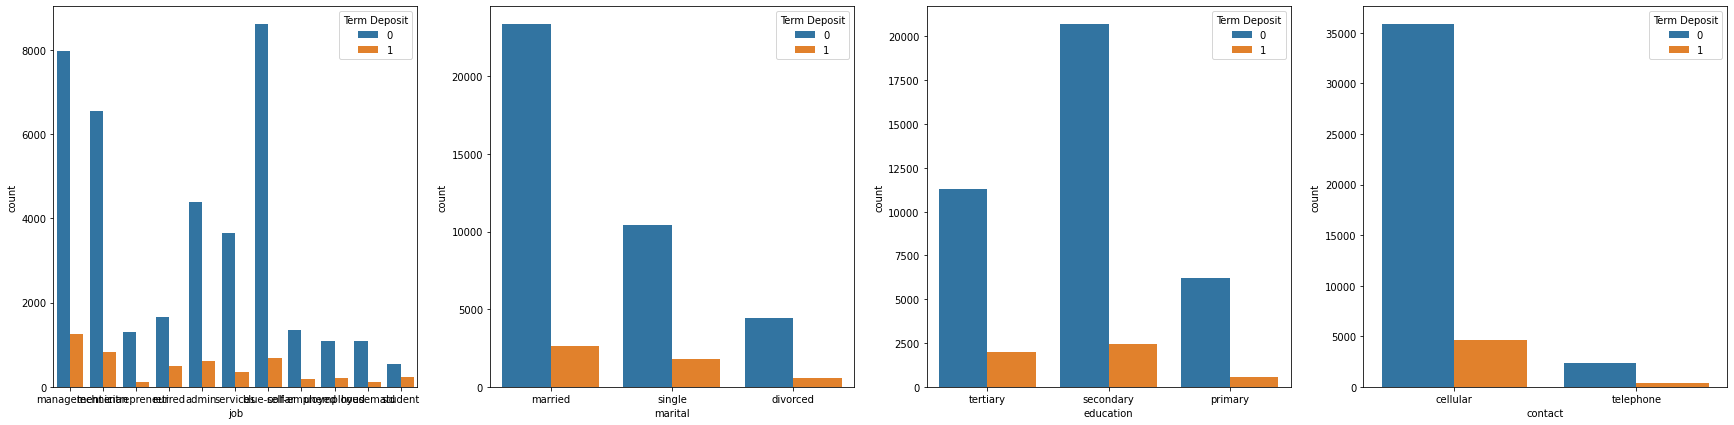

In [17]:
cat_cols=bank.select_dtypes(include='object').columns
fig, axes = plt.subplots(1, 4,figsize=(30,7))
j=0
for i in cat_cols:
  sns.countplot(x=bank[i],ax=axes[j],hue=bank['Term Deposit'])
  j+=1

We see that 94% of clients with negative balance do not get loans

In [18]:
bank.loc[bank.balance<0]['Term Deposit'].value_counts()/bank.loc[bank.balance<0].shape[0]

0    0.943038
1    0.056962
Name: Term Deposit, dtype: float64

In [19]:
bank.loc[bank['last contact']>0]['Term Deposit'].value_counts()

0    6113
1    1799
Name: Term Deposit, dtype: int64

last contact contains -1 95% of the data which means this person has not been contacted by a campaign before or the info is unknown, i first thought of dropping the column but based on the low number of features and after checking its correlation with the target column i decided to leave it as is and even open for further changes

In [20]:
#bank['year']=datetime.datetime.now().year

In [21]:
#bank['date']=pd.to_datetime(bank[["year","month", "day"]])
#bank=bank.drop('year',axis=1)

In [22]:
bank

,age,job,marital,education,Failed Payments,balance,housing loan,personal loan,contact,day,month,last contact duration,ncontacts,last contact,previous contacts,Term Deposit
0,58,management,married,tertiary,0,2143,1,0,cellular,5,5,261,1,-1,0,0
1,44,technician,single,secondary,0,29,1,0,cellular,5,5,151,1,-1,0,0
2,33,entrepreneur,married,secondary,0,2,1,1,cellular,5,5,76,1,-1,0,0
5,35,management,married,tertiary,0,231,1,0,cellular,5,5,139,1,-1,0,0
6,28,management,single,tertiary,0,447,1,1,cellular,5,5,217,1,-1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,0,825,0,0,cellular,17,11,977,3,-1,0,1
45207,71,retired,divorced,primary,0,1729,0,0,cellular,17,11,456,2,-1,0,1
45208,72,retired,married,secondary,0,5715,0,0,cellular,17,11,1127,5,184,3,1
45209,57,blue-collar,married,secondary,0,668,0,0,telephone,17,11,508,4,-1,0,0


In [23]:
bank.corr()['Term Deposit'].sort_values(ascending=False)

Term Deposit             1.000000
last contact duration    0.397393
last contact             0.101446
previous contacts        0.091764
balance                  0.051386
age                      0.024760
month                    0.016888
Failed Payments         -0.023244
day                     -0.030247
personal loan           -0.068802
ncontacts               -0.072465
housing loan            -0.138300
Name: Term Deposit, dtype: float64

In [24]:
bank.describe()

,age,Failed Payments,balance,housing loan,personal loan,day,month,last contact duration,ncontacts,last contact,previous contacts,Term Deposit
count,43193.000000,43193.000000,43193.000000,43193.000000,43193.000000,43193.000000,43193.000000,43193.000000,43193.000000,43193.000000,43193.000000,43193.000000
mean,40.764082,0.018105,1354.027342,0.562406,0.164541,15.809414,6.151483,258.323409,2.758178,40.404070,0.584863,0.116246
std,10.512640,0.133332,3042.103625,0.496096,0.370770,8.305970,2.409781,258.162006,3.063987,100.420624,2.332672,0.320523
min,18.000000,0.000000,-8019.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,-1.000000,0.000000,0.000000
25%,33.000000,0.000000,71.000000,0.000000,0.000000,8.000000,5.000000,103.000000,1.000000,-1.000000,0.000000,0.000000
50%,39.000000,0.000000,442.000000,1.000000,0.000000,16.000000,6.000000,180.000000,2.000000,-1.000000,0.000000,0.000000
75%,48.000000,0.000000,1412.000000,1.000000,0.000000,21.000000,8.000000,318.000000,3.000000,-1.000000,0.000000,0.000000
max,95.000000,1.000000,102127.000000,1.000000,1.000000,31.000000,12.000000,4918.000000,58.000000,871.000000,275.000000,1.000000


outliers worth the look at balance

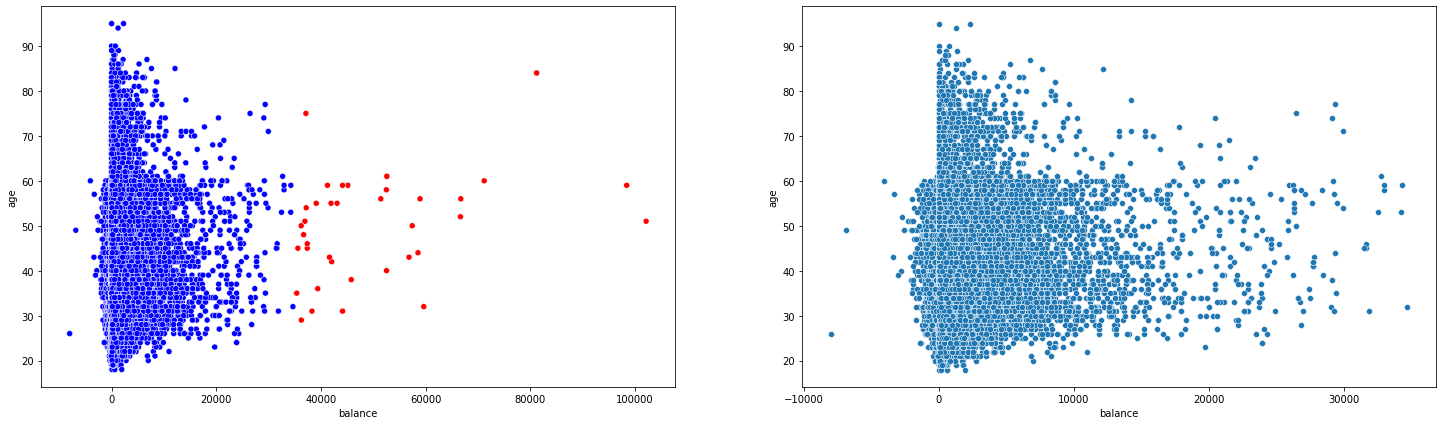

In [25]:
from sklearn import preprocessing
plot , ax = plt.subplots(1 , 2 , figsize = (25 , 7))

outliers = bank["balance"]>35000
sns.scatterplot(data=bank, x="balance", y="age",c = ["red" if is_outlier  else "blue" for is_outlier  in outliers],ax=ax[0])

bank.drop(bank[outliers].index , inplace = True)
sns.scatterplot(data = bank ,x="balance", y="age",ax=ax[1])

In [26]:
bank.shape

(43154, 16)

In [27]:
bank.select_dtypes(exclude='object')

,age,Failed Payments,balance,housing loan,personal loan,day,month,last contact duration,ncontacts,last contact,previous contacts,Term Deposit
0,58,0,2143,1,0,5,5,261,1,-1,0,0
1,44,0,29,1,0,5,5,151,1,-1,0,0
2,33,0,2,1,1,5,5,76,1,-1,0,0
5,35,0,231,1,0,5,5,139,1,-1,0,0
6,28,0,447,1,1,5,5,217,1,-1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,0,825,0,0,17,11,977,3,-1,0,1
45207,71,0,1729,0,0,17,11,456,2,-1,0,1
45208,72,0,5715,0,0,17,11,1127,5,184,3,1
45209,57,0,668,0,0,17,11,508,4,-1,0,0


<Figure size 432x288 with 0 Axes>

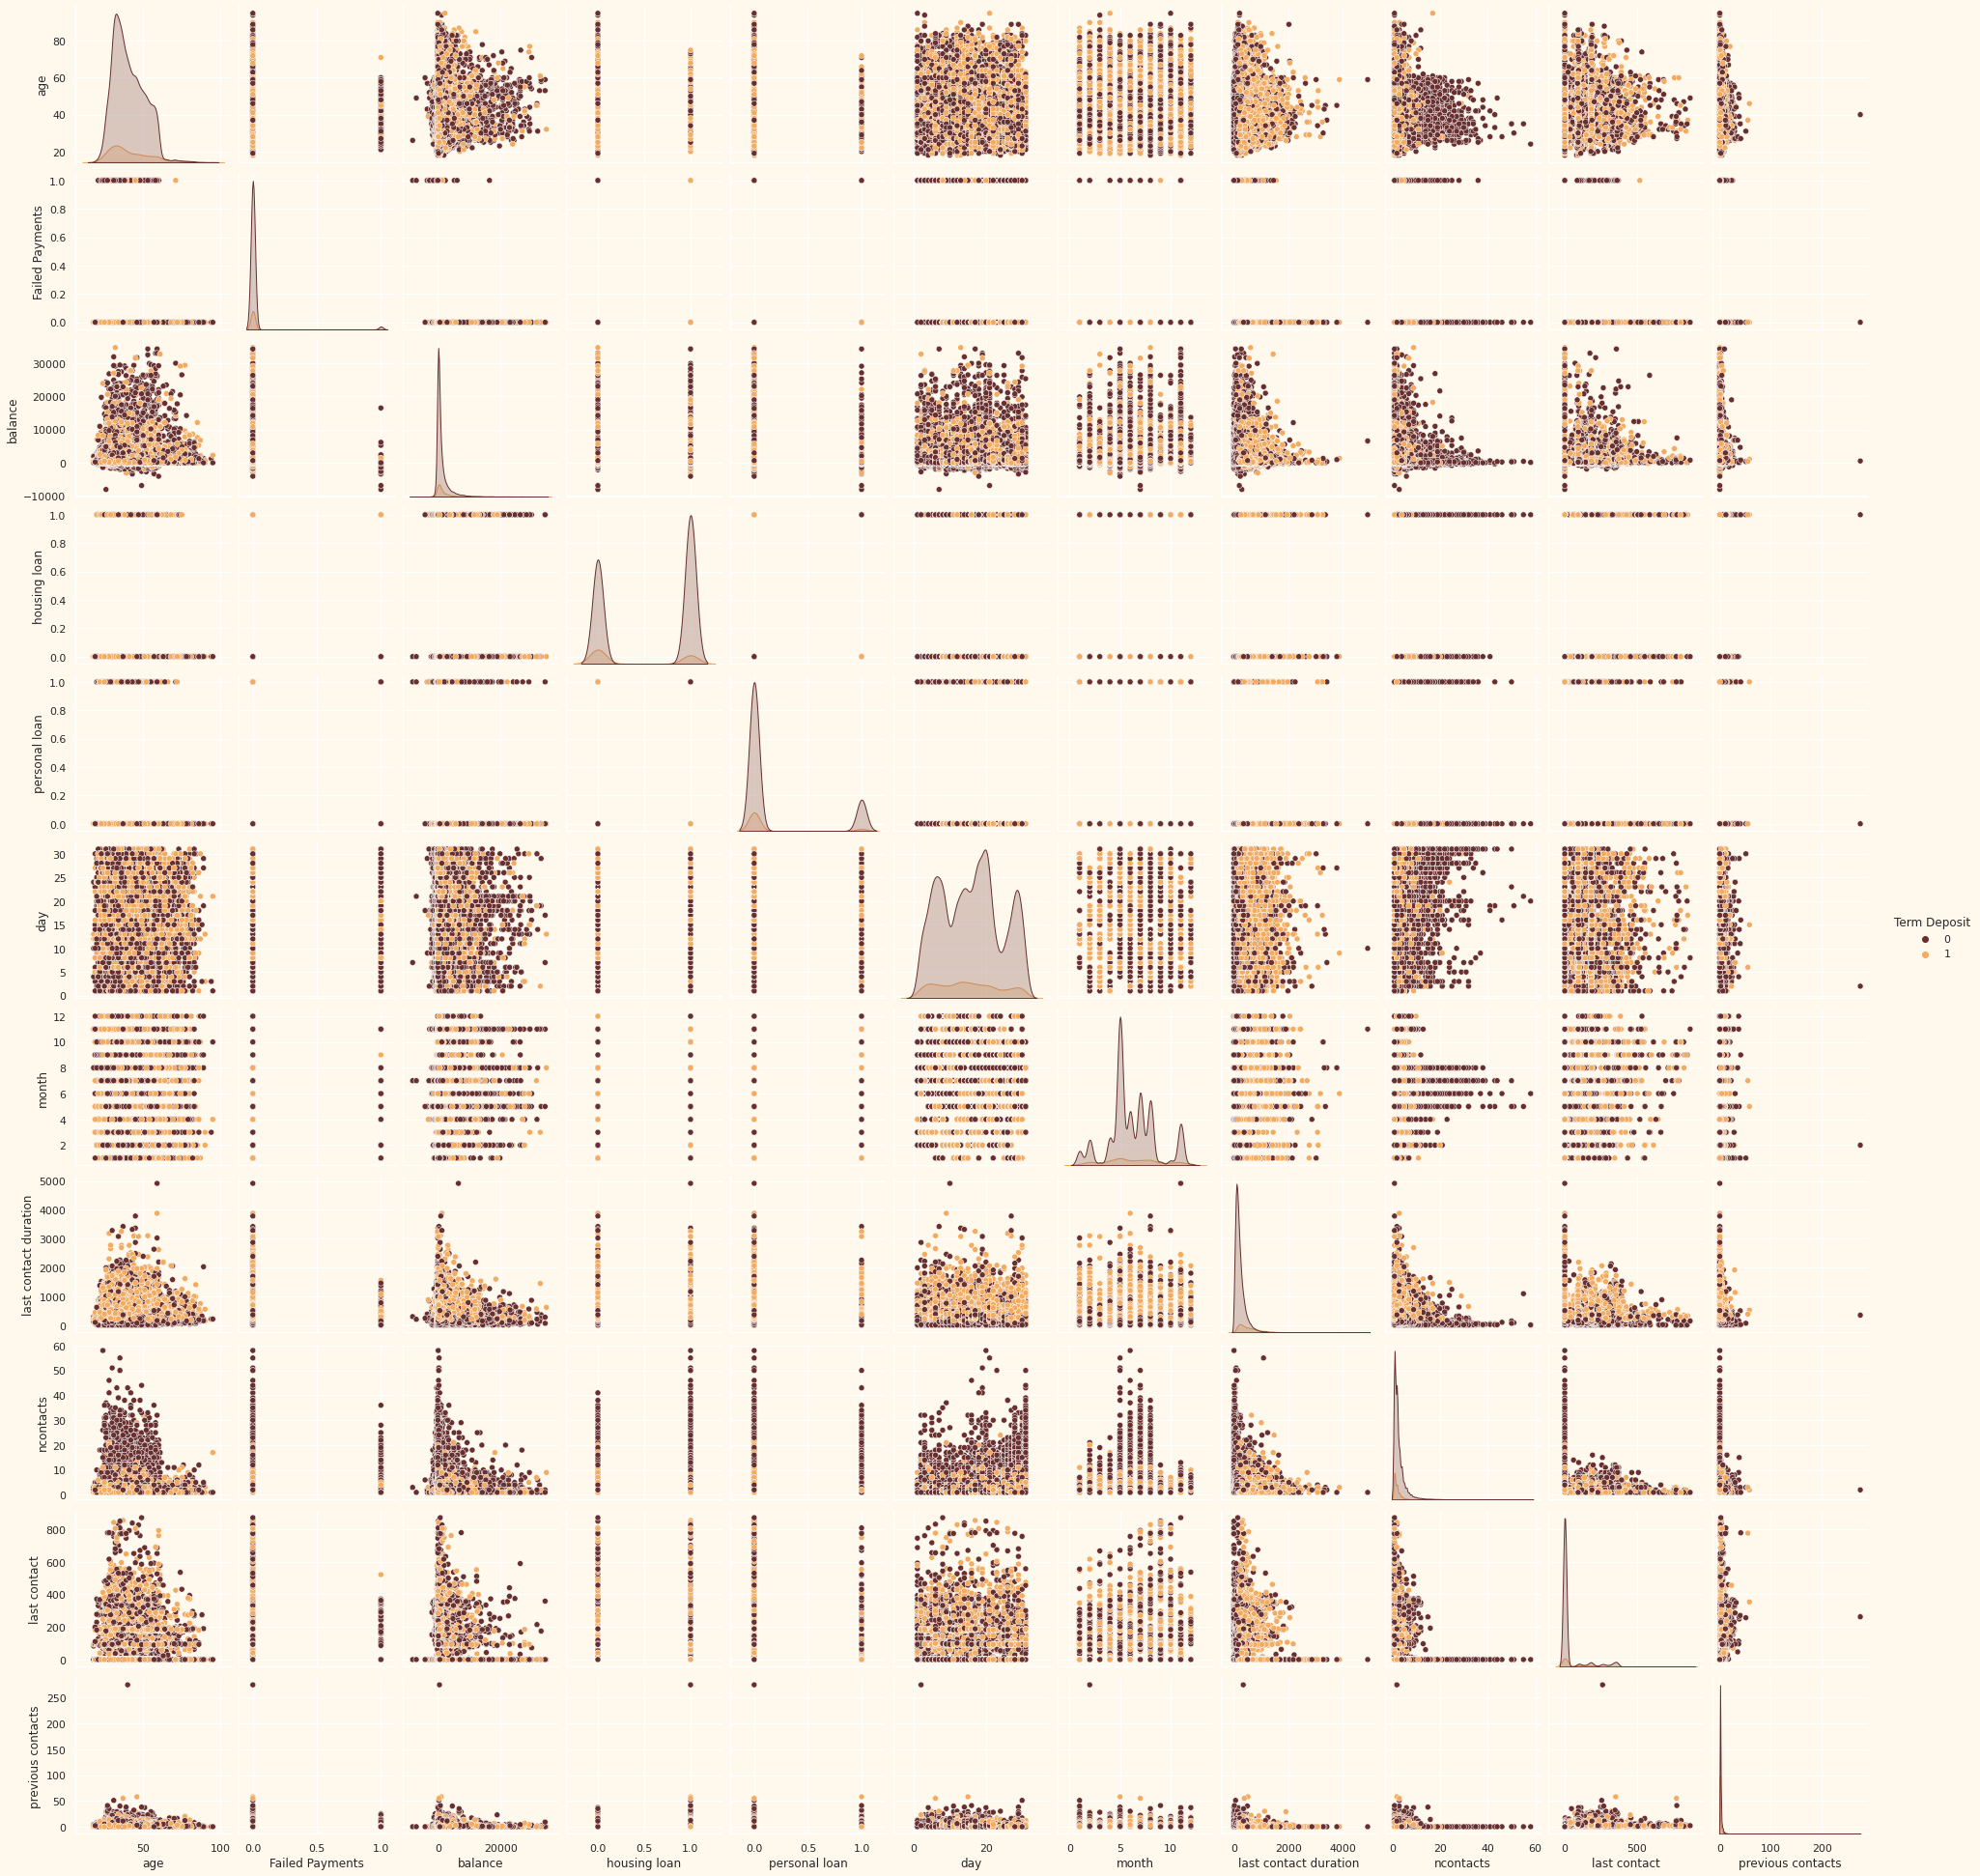

In [28]:
sns.set(rc={"axes.facecolor":"#FFF9ED","figure.facecolor":"#FFF9ED"})
pallet = ["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"]
cmap = colors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])

plt.figure()
sns.pairplot(bank.select_dtypes(exclude='object'), hue= "Term Deposit",palette= (["#682F2F","#F3AB60"]))

plt.show()

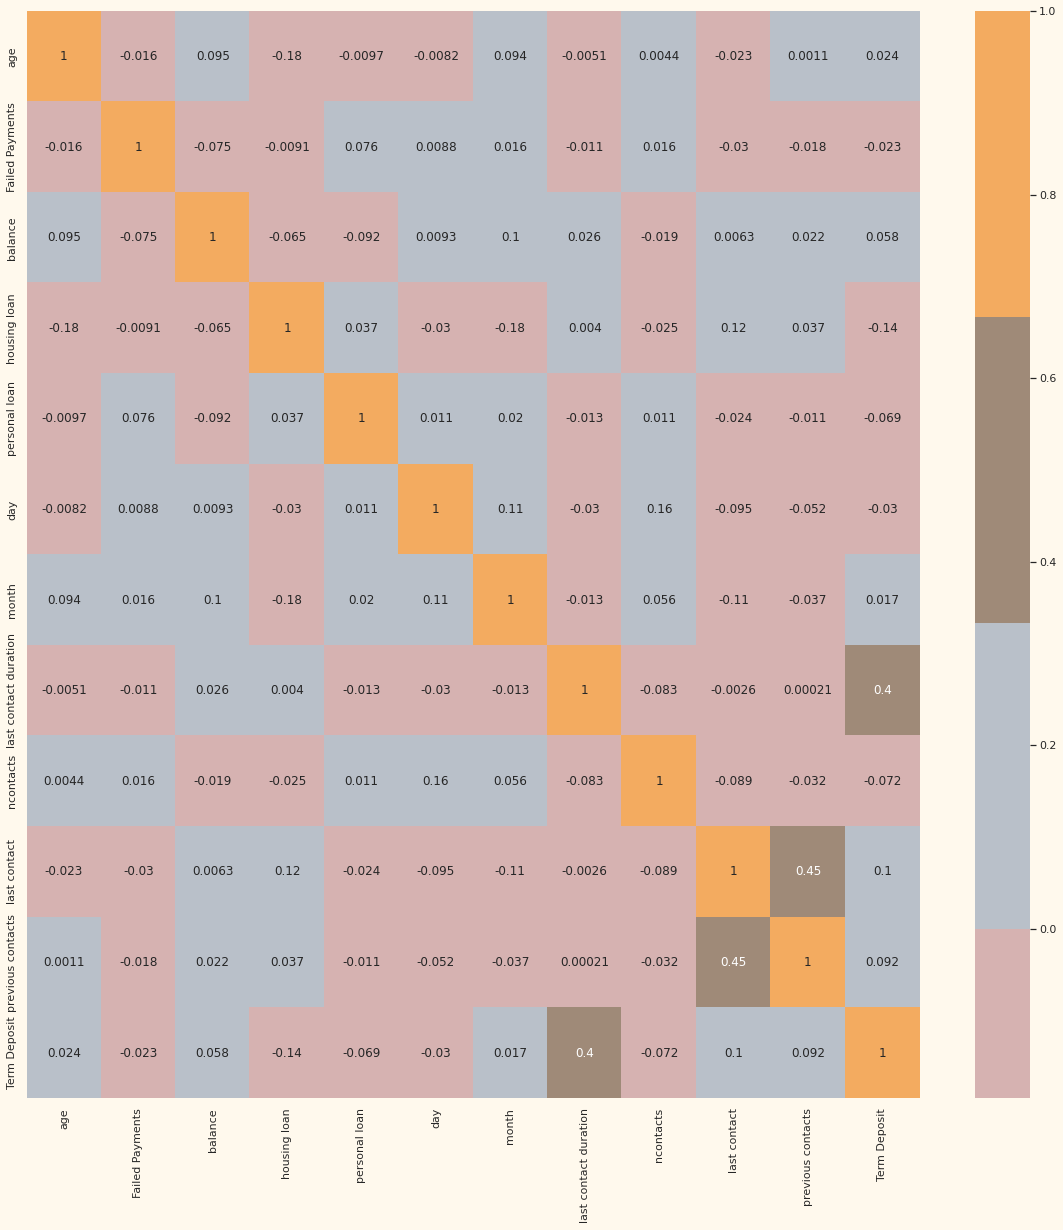

In [29]:
corrmat= bank.corr()
plt.figure(figsize=(20,20))  
sns.heatmap(corrmat,annot=True, cmap=cmap, center=0)

In [30]:
cp_bank=bank.copy()

In [31]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
#scaler.fit(cp_bank.select_dtypes(exclude='object'))
#temp = pd.DataFrame(scaler.transform(cp_bank.select_dtypes(exclude='object')),columns= cp_bank.select_dtypes(exclude='object').columns)
cp_bank=pd.get_dummies(cp_bank, drop_first=True)
cp_bank

,age,Failed Payments,balance,housing loan,personal loan,day,month,last contact duration,ncontacts,last contact,...,job_self-employed,job_services,job_student,job_technician,job_unemployed,marital_married,marital_single,education_secondary,education_tertiary,contact_telephone
0,58,0,2143,1,0,5,5,261,1,-1,...,0,0,0,0,0,1,0,0,1,0
1,44,0,29,1,0,5,5,151,1,-1,...,0,0,0,1,0,0,1,1,0,0
2,33,0,2,1,1,5,5,76,1,-1,...,0,0,0,0,0,1,0,1,0,0
5,35,0,231,1,0,5,5,139,1,-1,...,0,0,0,0,0,1,0,0,1,0
6,28,0,447,1,1,5,5,217,1,-1,...,0,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,0,825,0,0,17,11,977,3,-1,...,0,0,0,1,0,1,0,0,1,0
45207,71,0,1729,0,0,17,11,456,2,-1,...,0,0,0,0,0,0,0,0,0,0
45208,72,0,5715,0,0,17,11,1127,5,184,...,0,0,0,0,0,1,0,1,0,0
45209,57,0,668,0,0,17,11,508,4,-1,...,0,0,0,0,0,1,0,1,0,1


In [32]:
X=cp_bank.drop('Term Deposit',axis=1)
y=cp_bank['Term Deposit']

In [33]:
def predictbasicmodels(X,y):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
  print("X set has {} samples.".format(X.shape))
  print("Training set has {} samples.".format(X_train.shape[0]))
  print("Testing set has {} samples.".format(X_test.shape[0]))
  print()
  clf_A = SVC(random_state=3)
  clf_B = LogisticRegression(random_state=3)
  clf_C = GaussianNB()

  results = {}
  for clf in [clf_A, clf_B, clf_C]:
      clf_name = clf.__class__.__name__
      results[clf_name] = {}
      results[clf_name] = \
      results = {}
      clf = clf.fit(X_train, y_train)
        
      predictions_test = clf.predict(X_test)
      print(clf)
      print('Accuracy Score: ' + str(accuracy_score(y_test,predictions_test)))
      print('fb Score: '+ str(fbeta_score(y_test,predictions_test,beta=0.5)))
      print()
  return X_train, X_test, y_train, y_test

def predictadvmodels(X,y):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
  print("Training set has {} samples.".format(X_train.shape[0]))
  print("Testing set has {} samples.".format(X_test.shape[0]))
  print()
  clf_A = RandomForestClassifier(random_state=3)
  clf_B = DecisionTreeClassifier(random_state=3)
  clf_C = AdaBoostClassifier(random_state=3)

  results = {}
  for clf in [clf_A, clf_B, clf_C]:
      clf_name = clf.__class__.__name__
      results[clf_name] = {}
      results[clf_name] = \
      results = {}
      clf = clf.fit(X_train, y_train)
        
      predictions_test = clf.predict(X_test)
      print(clf)
      print('Accuracy Score: ' + str(accuracy_score(y_test,predictions_test)))
      print('fb Score: '+ str(fbeta_score(y_test,predictions_test,beta=0.5)))
      print()
  return X_train, X_test, y_train, y_test

In [34]:
X_train, X_test, y_train, y_test=predictbasicmodels(X,y)

X set has (43154, 26) samples.
Training set has 34523 samples.
Testing set has 8631 samples.

SVC(random_state=3)
Accuracy Score: 0.8869192445834782
fb Score: 0.06899724011039558

LogisticRegression(random_state=3)
Accuracy Score: 0.8874985517321283
fb Score: 0.35535307517084286

GaussianNB()
Accuracy Score: 0.8302630054454871
fb Score: 0.3281884646628757



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [35]:
X_train, X_test, y_train, y_test=predictadvmodels(X,y)

Training set has 34523 samples.
Testing set has 8631 samples.

RandomForestClassifier(random_state=3)
Accuracy Score: 0.9018653690186537
fb Score: 0.5395574416489846

DecisionTreeClassifier(random_state=3)
Accuracy Score: 0.8653690186536902
fb Score: 0.42150333016175073

AdaBoostClassifier(random_state=3)
Accuracy Score: 0.8957247132429614
fb Score: 0.49248480972177805



In [36]:
def Gridsrch(clf):

  parameters={'n_estimators':[200,300,500],'min_samples_split':[2,3]}
  scorer=make_scorer(accuracy_score)
  grid_layout=GridSearchCV(clf,parameters,scoring=scorer)

  grid_fit=grid_layout.fit(X_train,y_train)

  best_clf=grid_fit.best_estimator_

  #predict using plane and optimized model
  predictions=(clf.fit(X_train,y_train).predict(X_test))
  best_predictions=best_clf.predict(X_test)
  print(str(clf) +" before Optimization: " + str(accuracy_score(y_test,predictions)))
  print(str(clf) +" after Optimization: " + str(accuracy_score(y_test,best_predictions)))
  print(grid_fit.best_params_)
  return grid_fit


In [ ]:
grid_fit=Gridsrch(RandomForestClassifier(random_state=3))

In [ ]:
banktwo=pd.read_csv('bank.csv',sep=';')

In [ ]:
def preprocessdata(data):
  data.rename(columns={'default': 'Failed Payments', 'duration': 'last contact duration','previous':'previous contacts','y':'Term Deposit','housing':'housing loan','loan':'personal loan','campaign':'ncontacts','pdays':'last contact'}, inplace=True)
  cols=data.loc[:,data.nunique()==2].columns
  for j in cols:
    data[j]=data[j].map({'yes': 1, 'no': 0})
  
  data.month=data.month.map({'jan': 1, 'feb': 2,'mar': 3, 'apr': 4,'may': 5, 'jun': 6,'jul': 7, 'aug': 8,'sep': 9, 'oct': 10,'nov': 11, 'dec': 12})

  for j in data.columns:
    data[j]=data[j].replace('unknown',pd.NA)

  data=data.drop(columns='poutcome',axis=1)
  data['contact']=data['contact'].replace(pd.NA,bank.contact.mode()[0])
  data = data.dropna()
  data=pd.get_dummies(data, drop_first=True)
  newX=data.drop('Term Deposit',axis=1)
  newy=data['Term Deposit']
  return newX,newy

In [ ]:
newX,newy=preprocessdata(banktwo)

In [ ]:
preds=grid_fit.best_estimator_.predict(newX)

In [ ]:
print(str(grid_fit.best_estimator_) +" Score on test file: " + str(accuracy_score(newy,preds)))